<a href="https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/m3_time_series_prediction1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip uninstall tensorflow-gpu==2.0.0-alpha0

In [0]:
#!pip install tensorflow-gpu==2.0.0-alpha0
pip install tf-nightly-gpu

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [0]:
from pandas_datareader import data

In [0]:
tickers = 'AAPL'

#start_date = '1980-12-01'
start_date = '2016-12-01'
end_date = '2019-05-01'

stock_data = data.get_data_yahoo(tickers, start_date, end_date)

In [5]:
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-01,110.940002,109.029999,110.370003,109.489998,37086900.0,105.709946
2016-12-02,110.089996,108.849998,109.169998,109.900002,26528000.0,106.105789
2016-12-05,110.029999,108.250000,110.000000,109.110001,34324500.0,105.343063
2016-12-06,110.360001,109.190002,109.500000,109.949997,26195500.0,106.154060
2016-12-07,111.190002,109.160004,109.260002,111.029999,29998700.0,107.196770


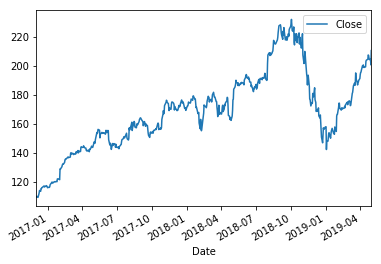

In [6]:
stock_data_frame = stock_data[["Close"]]
stock_data_frame.plot()

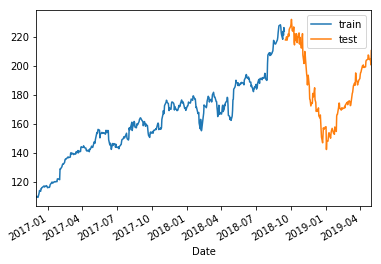

In [40]:
split_date = pd.Timestamp('2018-09-15')
train = stock_data_frame.loc[:split_date]
test = stock_data_frame.loc[split_date:]
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])


In [0]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [0]:

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [0]:

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [0]:
import tensorflow as tf

In [45]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
449/449 [==============================] - 3s 7ms/sample - loss: 0.0377
Epoch 2/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0247
Epoch 3/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0154
Epoch 4/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0077
Epoch 5/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0041
Epoch 6/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0025
Epoch 7/200
449/449 [==============================] - 2s 4ms/sample - loss: 0.0017
Epoch 8/200
449/449 [==============================] - 2s 5ms/sample - loss: 0.0013
Epoch 9/200
449/449 [==============================] - 2s 5ms/sample - loss: 0.0011
Epoch 10/200
449/449 [==============================] - 2s 5ms/sample - loss: 9.3928e-04
Epoch 11/200
449/449 [==============================] - 2s 5ms/sample - loss: 8.6084e-04
Epoch 12/200
449/449 [==============================] - 2s 5ms/sam

In [0]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

R2, Anpassungsgüte der Regession: 0 = kein Linearer Zusammenhang, 1 perfekter linearer Zusammenhang

In [47]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.974
The Adjusted R2 score on the Train set is:	0.974

The R2 score on the Test set is:	0.953
The Adjusted R2 score on the Test set is:	0.953


In [0]:
model_lstm.save('LSTM_NonShift_v2.h5')

In [0]:
model_lstm = tf.keras.models.load_model('LSTM_NonShift_v2.h5')

In [50]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

155/155 [==============================] - 1s 5ms/sample - loss: 0.0018


In [51]:
print('LSTM: %f'%score_lstm)

LSTM: 0.001847


In [0]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

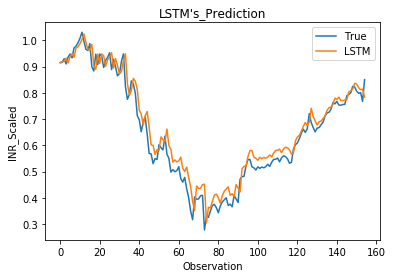

In [53]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()